In [2]:
from __future__ import print_function
import pandas as pd
import numpy as np
import math
from sklearn.metrics import confusion_matrix 
from scipy import stats
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# utilities

def listify(df, column):
    matches = [i for i,n in enumerate(df.columns) if n==column]

    if len(matches)==0:
        raise Exception('Failed to find column named ' + column +'!')
  
    if len(matches)>1:
        raise Exception('More than one column named ' + column +'!')

    old_index = df.index
    col_idx = matches[0] + len(old_index.shape) # Since we will reset the index

    column_names = list(df.index.names) + list(df.columns)
    gb_cols = [c for c in column_names if c!= column]

    # Helper function to generate the squashed dataframe
    def fnc(d):
        row = list(d.values[0])
        return pd.DataFrame([row[:col_idx]
                         + [[v[col_idx] for v in list(d.values)]]
                         + row[col_idx+1:]])

    return (df
          .reset_index()
          .groupby(gb_cols)
          .apply(fnc)
          .rename(columns = lambda i : column_names[i])
          .set_index(old_index.names)
          )

def unlistify(df, column):
    matches = [i for i,n in enumerate(df.columns)
             if n==column]

    if len(matches)==0:
        raise Exception('Failed to find column named ' + column +'!')
    if len(matches)>1:
        raise Exception('More than one column named ' + column +'!')

    col_idx = matches[0]

    # Helper function to expand and repeat the column col_idx
    def fnc(d):
        row = list(d.values[0])
        bef = row[:col_idx]
        aft = row[col_idx+1:]
        col = row[col_idx]
        z = [bef + [c] + aft for c in col]
        return pd.DataFrame(z)

    col_idx += len(df.index.shape) # Since we will push reset the index
    index_names = list(df.index.names)
    column_names = list(index_names) + list(df.columns)
    return (df
          .reset_index()
          .groupby(level=0,as_index=0)
          .apply(fnc)
          .rename(columns = lambda i :column_names[i])
          .set_index(index_names)
          )

In [4]:
# read data
policy_df = pd.read_csv("./data/PolicyLevel.csv")

"""
                        # Data Preparation & Feature generation#
Generate a single record per policy that retains max information possible
"""

# Last seen Date: CancelDate if not null else '2016-12-31' (Last date in the data set)
policy_df['LastSeenDate'] = policy_df['CancelDate']
policy_df['LastSeenDate'].fillna(pd.to_datetime('2016-12-31'), inplace=True)

# Date conversions
policy_df['EnrollDate'] = pd.to_datetime(policy_df['EnrollDate']).dt.to_period('m')
policy_df['CancelDate'] = pd.to_datetime(policy_df['CancelDate']).dt.to_period('m')
policy_df['LastSeenDate'] = pd.to_datetime(policy_df['LastSeenDate']).dt.to_period('m')
                                                                     
display(policy_df.head())

,PolicyId,EnrollDate,CancelDate,MonthlyPremium,LastSeenDate
0,92597,2010-12,NaT,34.54,2016-12
1,92808,2010-11,NaT,18.54,2016-12
2,93090,2010-11,NaT,23.53,2016-12
3,93122,2010-11,NaT,44.02,2016-12
4,93133,2010-11,NaT,32.46,2016-12


In [4]:
policy_df['dates'] = policy_df[['EnrollDate', 'LastSeenDate']].apply(
    lambda x: pd.date_range(x['EnrollDate'].to_timestamp(),  x['LastSeenDate'].to_timestamp(), 
                            freq='M').tolist(), axis=1)
policy_df['dates'] = policy_df['dates'].apply(lambda dates: [date.to_period('m') for date in dates])

In [5]:
policy_df = unlistify(policy_df, 'dates')
policy_df = policy_df[['PolicyId', 'MonthlyPremium', 'dates']]
policy_df = policy_df.pivot(index='PolicyId', columns='dates')
policy_df.columns = policy_df.columns.droplevel(0)
policy_df = policy_df.reset_index()

In [6]:
policy_df.head()

dates,PolicyId,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,...,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11
0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.78,21.78,21.78,21.78,21.78,21.78,21.78,21.78,21.78,21.78
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.36,24.36,24.36,24.36,24.36,24.36,24.36,24.36,24.36,24.36
2,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46.00,46.00,46.00,46.00,46.00,46.00,46.00,46.00,46.00,46.00
3,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.83,23.83,23.83,23.83,23.83,23.83,23.83,23.83,23.83,23.83
4,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.77,26.77,26.77,26.77,26.77,26.77,26.77,26.77,26.77,26.77


In [22]:
policy_df.to_csv('./data/policy_df_monthy_per_policy.csv', index=False)

In [133]:
policy_df = pd.read_csv('./data/policy_df_monthy_per_policy.csv')

In [134]:
width = 8
height = 8

active_policies = policy_df[list(set(policy_df.columns.values.tolist()) - set(['PolicyId']))].nunique()
active_policies.index = active_policies.index.map(np.datetime64)
active_policies = active_policies.sort_index()

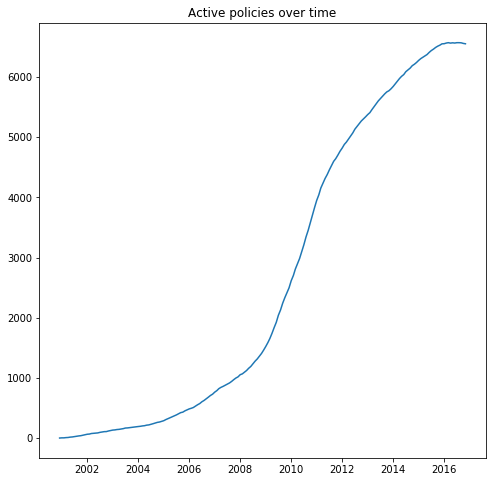

In [135]:
plt.figure(figsize=(width, height))
plt.figure(figsize=(width, height))
plt.plot([x for x in active_policies.index.tolist()], active_policies.values.tolist())
plt.title("Active policies over time")
plt.show()

In [136]:
columns = policy_df.columns
new_policy_df = policy_df.apply(lambda x: [1 if (np.isnan(x[i-1]) and ~np.isnan(x[i])) else np.nan 
                                           for i in range(1,len(x))], axis=1)
new_policy_df = pd.DataFrame([i for i in new_policy_df], columns=columns[1:])
lost_policy_df = policy_df.apply(lambda x: [1 if (~np.isnan(x[i-1]) and np.isnan(x[i])) else np.nan 
                                           for i in range(1,len(x))], axis=1)
lost_policy_df = pd.DataFrame([i for i in lost_policy_df], columns=columns[1:])

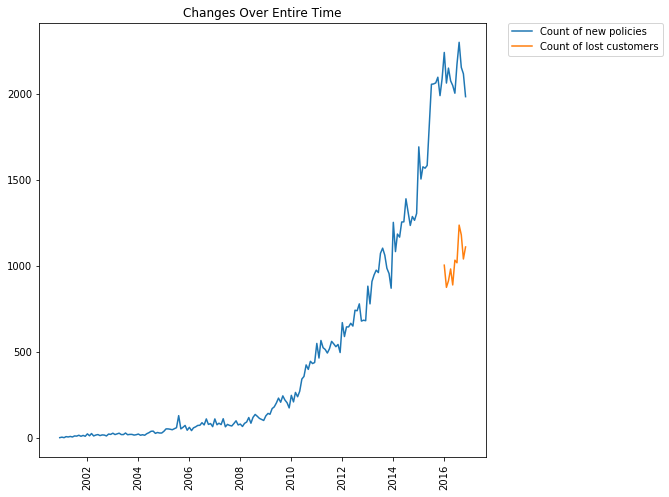

In [156]:
new_policies = new_policy_df[list(set(new_policy_df.columns.values.tolist()) - set(['PolicyId']))].count()
new_policies.index = new_policies.index.map(np.datetime64)
new_policies = new_policies.sort_index()

lost_policies = lost_policy_df[list(set(lost_policy_df.columns.values.tolist()) - set(['PolicyId']))].count()
lost_policies.index = lost_policies.index.map(np.datetime64)
lost_policies = lost_policies.sort_index()

plt.figure(figsize=(width, height))
plt.figure(figsize=(width, height))
plt.plot([x for x in new_policies.index.tolist()], new_policies.values.tolist(), 
         label="Count of new policies")
plt.plot([x for x in lost_policies.index.tolist()[-11:]], lost_policies.values.tolist()[-11:],
         label="Count of lost customers")
plt.title("Changes Over Entire Time")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

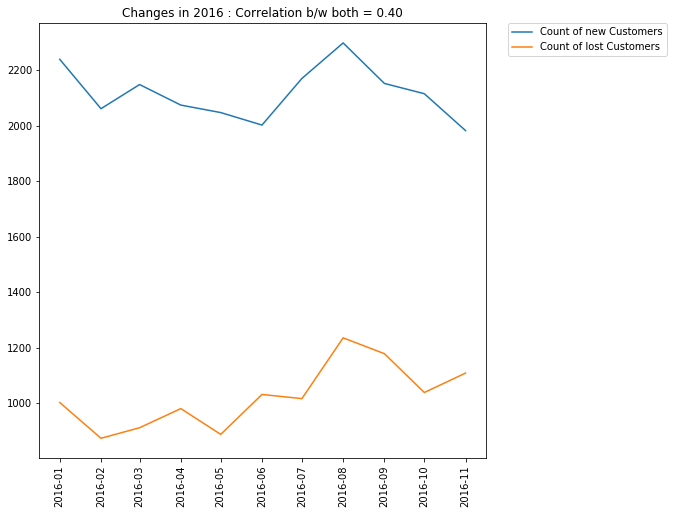

In [154]:
plt.figure(figsize=(width, height))
plt.plot([x for x in new_policies.index.tolist()[-11:]], new_policies.values.tolist()[-11:], 
         label="Count of new Customers")
plt.plot([x for x in lost_policies.index.tolist()[-11:]], lost_policies.values.tolist()[-11:],
        label="Count of lost Customers")


corr = stats.pearsonr(new_policies.values.tolist()[-11:], lost_policies.values.tolist()[-11:])[0]
plt.title("Changes in 2016 : Correlation b/w both = %.2f"%(corr))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

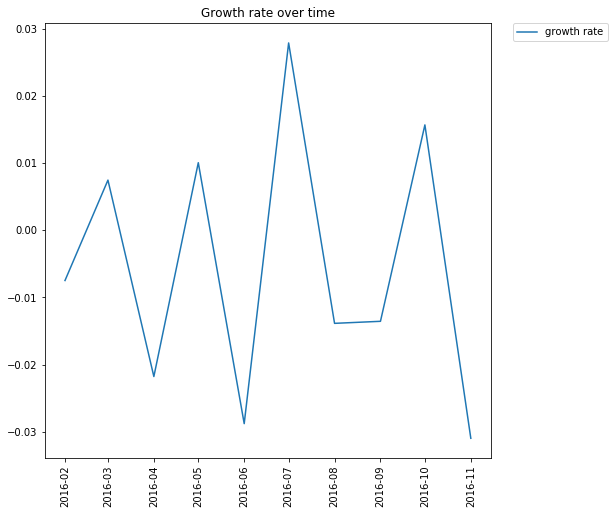

In [157]:
# Year 2016 Growth
plt.figure(figsize=(width, height))
active_policies_count = active_policies.values.tolist()[-11:]
policy_increase_per_month = [x-y for x,y in zip([x for x in new_policies.values.tolist()[-11:]], 
                             [x for x in lost_policies.values.tolist()[-11:]])]
growth_rate = [(policy_increase_per_month[i] - policy_increase_per_month[i-1]) /
                active_policies_count[i-1] 
               for i in range(1,len(policy_increase_per_month))]
plt.plot(new_policies.index.tolist()[-10:], growth_rate, label="growth rate")
plt.title("Growth rate over time")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

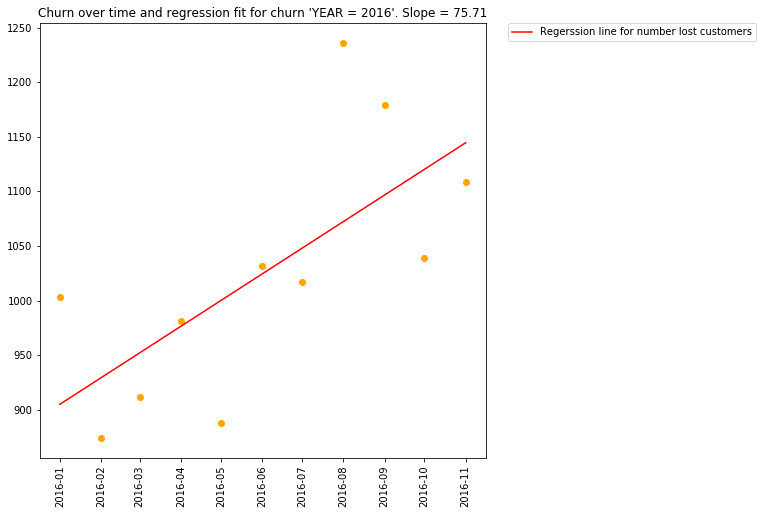

In [161]:
# regression on churn customers
from sklearn import linear_model

plt.figure(figsize=(width, height))
plt.plot([x for x in lost_policies.index.tolist()[-11:]], lost_policies.values.tolist()[-11:], 'yo'
        ,  c="orange")

x = (lost_policies.index.values[-11:] - lost_policies.index.values[-12]).tolist()
x = (x - np.mean(x))/np.std(x)
coeff = np.polyfit(x, lost_policies.values.tolist()[-11:], deg=1)
lm = lambda x: (coeff[1] + coeff[0]*(x))
y = lm(x)
plt.plot([x for x in lost_policies.index.tolist()[-11:]], lm(x), c='r', 
         label="Regerssion line for number lost customers")
plt.title("Churn over time and regression fit for churn 'YEAR = 2016'. Slope = %.2f"%(coeff[0]))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

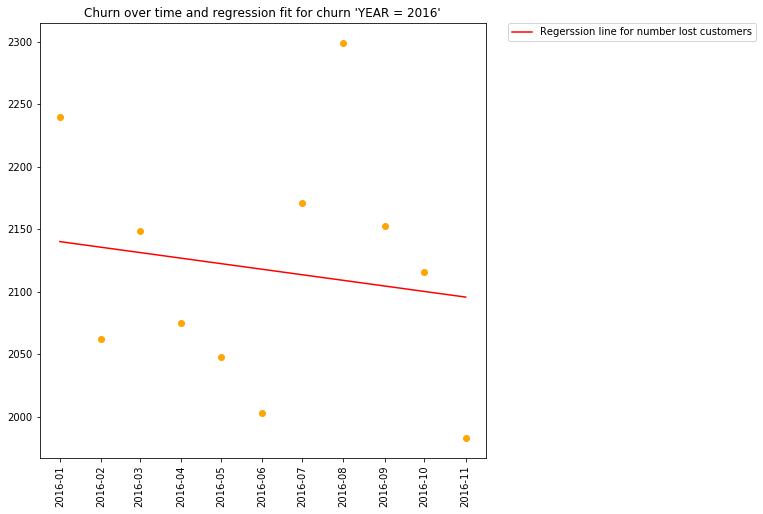

In [160]:
# regression on new customers
from sklearn import linear_model

plt.figure(figsize=(width, height))
plt.plot([x for x in new_policies.index.tolist()[-11:]], new_policies.values.tolist()[-11:], 'yo'
        ,  c="orange")

x = (new_policies.index.values[-11:] - new_policies.index.values[-12]).tolist()
x = (x - np.mean(x))/np.std(x)
coeff = np.polyfit(x, new_policies.values.tolist()[-11:], deg=1)
lm = lambda x: (coeff[1] + coeff[0]*(x))
y = lm(x)
plt.plot([x for x in new_policies.index.tolist()[-11:]], lm(x), c='r', 
         label="Regerssion line for number lost customers")
plt.title("Churn over time and regression fit for churn 'YEAR = 2016'")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()